# Алгоритмы интеллектуальной обработки больших объемов данных
## Домашнее задание №4 - Метод k-средних, предобработка признаков


###### <hr\>
**Общая информация**

**Срок сдачи:** 25 апреля 2018, 06:00 <br\>
**Штраф за опоздание:** -2 балла после 06:00 25 апреля, -4 баллов после 06:00 2 мая, -6 баллов после 06:00 9 мая

При отправлении ДЗ указывайте фамилию в названии файла<br\>

Используйте данный Ipython Notebook при оформлении домашнего задания.

**Штрафные баллы:**

1. Невыполнение PEP8 -1 балл
2. Отсутствие фамилии в имени скрипта (скрипт должен называться по аналогии со stroykova_hw4.ipynb) -1 балл
3. Все строчки должны быть выполнены. Нужно, чтобы output команды можно было увидеть уже в git'е. В противном случае -1 балл
4. При оформлении ДЗ нужно пользоваться данным файлом в качестве шаблона. Не нужно удалять и видоизменять написанный код и текст. В противном случае -1 балл
<hr\>

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics

%matplotlib inline

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)
plt.rcParams['font.size'] = 14
plt.rcParams['legend.fontsize'] =  14

%load_ext pycodestyle_magic

The pycodestyle_magic extension is already loaded. To reload it, use:
  %reload_ext pycodestyle_magic


# Имплементация K-means

Пользуясь наработками выше, имплементируйте метод k-means.  
При инициализации необходимо задавать количество кластеров, функцию расстояния между кластерами (для оригинального k-means - евклидово расстояние) и начальное состояние генератора случайных чисел.

После обучения, среди атрибутов класса `Kmeans` должны появится
* Метки кластеров для объектов
* Координаты центройдов кластеров

k-means - это алгоритм **кластеризации**, а не классификации, а посему метод `.predict()` в нем фактически не нужен, но он может возвращать метки ближайшего кластера для объектов.

###### Задание 1 (2 баллов)
Имплементируйте метод k-means. Задание считается выполненным, если Ваша реализация работает быстрее реализации из sklearn.

Теория для выполнения задания 2 и 3 остаётся на самостоятельное изучение. Теории немного и она совсем простая.

###### Задание 2 (2 балла)
Имплементируйте класс MiniBatchKMeans, который является классом наследником Kmeans.

###### Задание 3 (2 балла)
Превратите k-means в k-means++. Для этого нужно реализовать метод в классе Kmeans, который будет инициализировать более "хорошие" значения центроидов. Чтобы использовался метод k-means++, в параметр init необходимо передать строковое значение 'k-means' (по умолчанию 'random').

###### Задание 4 (2 балла)
В пункте "Проверка корректности метода" нужно нарисовать графики, которые показывают зависимость времени выполнения алгоритма от количества сэмплов. Графики должны быть  нарисованы для различных комбинаций реализаций алгоритма (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). График достаточно построить на 5-10 точках.

###### Задание 5 (2 балла)
В пункте "Применение K-means на реальных данных" нужно сравнить различные реализации k-means (k-means, k-means++, k-means с MiniBatchKMeans, k-means++ с MiniBatchKMeans). После чего написать вывод, в котором должно быть объяснение того, почему один алгоритм оказался лучше остальных или почему не было выявлено лучшего алгоритма.

In [82]:
#%%pycodestyle


class MyKmeans:

    def __init__(self, k=2, metric='euclidean', max_iter=1000, random_state=None, init='random'):
        """
        Инициализация метода
        :k - количество кластеров
        :metric - функция расстояния между объектами
        :max_iter - максиальное количество итераций
        :random_state - seed для инициализации генератора случайных чисел
        """

        self.k = k
        self.random_state = random_state
        self.metric = metric
        self.max_iter = max_iter
        
        if init == 'k-means++':
            self.init_function = self.__init_proba
        elif init == 'random':
            self.init_function = self.__init_random
        else:
            print('Wrong init method name!')
            raise

    def __init_random(self, X):
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]

    def __init_proba(self, X):
        self.centroids[0] = X[np.random.choice(X.shape[0])]

        for i in range(1, self.k):
            distances = np.min(self.dist(X, self.centroids[:i]), axis=1)
            rand_sum = np.random.uniform(0, 1) * distances.sum()
            self.centroids[i] = X[np.cumsum(distances) > rand_sum][0]

    @staticmethod
    def dist(X, Y):
        x_dist = (X ** 2).sum(axis=1)
        y_dist = (Y ** 2).sum(axis=1)
        xy_dist = X.dot(Y.T)
        return - 2 * xy_dist + y_dist + x_dist.reshape(-1, 1)

    def fit(self, X, y=None):
        """
        Процедура обучения k-means
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(X.shape[0])

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        self.init_function(X)
        centroids = np.ones((self.k, X.shape[1]))

        for iteration in range(self.max_iter):
            distances = self.dist(self.centroids, X)
            self.labels = np.argmin(distances, axis=0)
            centroids = [np.mean(X[self.labels == label], axis=0) for label in range(self.k)]
            if np.array_equal(centroids, self.centroids):
                break
            self.centroids = np.copy(centroids)

        return self

    def predict(self, X, y=None):
        """
        Процедура предсказания кластера

        Возвращает метку ближайшего кластера для каждого объекта
        """
        distances = self.dist(self.centroids, X)
        labels = np.argmin(distances, axis=0)

        return labels


class MiniBatchKMeans(MyKmeans):

    def __init__(self, *args, **kwargs):

        self.mbatch_size = 10
        self.eps = 1
        if 'mbatch_size' in kwargs:
            self.mbatch_size = kwargs.pop('mbatch_size')
        if 'eps' in kwargs:
            self.eps = kwargs.pop('eps')
        super(MiniBatchKMeans, self).__init__(*args, **kwargs)

    def fit(self, X):
        """
        Обучение
        """

        # Инициализация генератора случайных чисел
        np.random.seed(self.random_state)

        # Массив с метками кластеров для каждого объекта из X
        self.labels = np.empty(self.mbatch_size)

        # Массив с центройдами кластеров
        self.centroids = np.empty((self.k, X.shape[1]))

        # Your Code Here
        self.init_function(X)
        centroids = np.ones((self.k, X.shape[1]))

        v = np.zeros(self.k)

        for iteration in range(self.max_iter):
            M = X[np.random.choice(X.shape[0], self.mbatch_size, replace=False)]
            distances = self.dist(self.centroids, M)
            self.labels = np.argmin(distances, axis=0)
            for i, x in enumerate(M):
                v[self.labels[i]] += 1
                lr = 1 / v[self.labels[i]]
                self.centroids[self.labels[i]] = (1 - lr) * self.centroids[self.labels[i]] + lr * x
            if np.linalg.norm(centroids - self.centroids) < self.eps:
                break
            centroids = np.copy(self.centroids)

        return self

### Проверка корректности метода

Перед тем как применять алгоритм на реальных данных, нужно испытать его на простых "игрушечных" данных.

Если алгоритм реализован правильно, то метод должен идеально разбивать на 3 кластера данные ниже. Проверьте это.

ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [83]:
from sklearn.datasets import make_blobs

In [84]:
X, y = make_blobs(n_samples=100, n_features=2, centers=3, cluster_std=1, 
           center_box=(-10.0, 10.0), shuffle=False, random_state=1234)

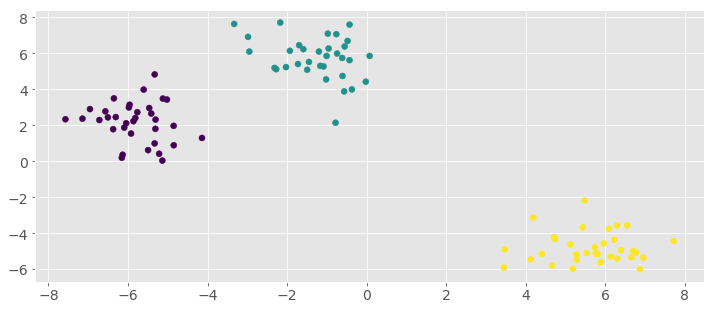

In [85]:
plt.scatter(X[:,0], X[:, 1], c=y)
plt.show()

Проверьте Вашу имплементацию на простых данных (без этого пункта ДЗ не считается выполненным).   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [86]:
def test(model):
    model.fit(X)
    y_predict = model.predict(X)
    for i in range(n_clusters):
        plt.scatter(model.centroids[i][0], model.centroids[i][1], s=1000)
    plt.scatter(X[:,0], X[:, 1], c=y_predict)
    plt.show()

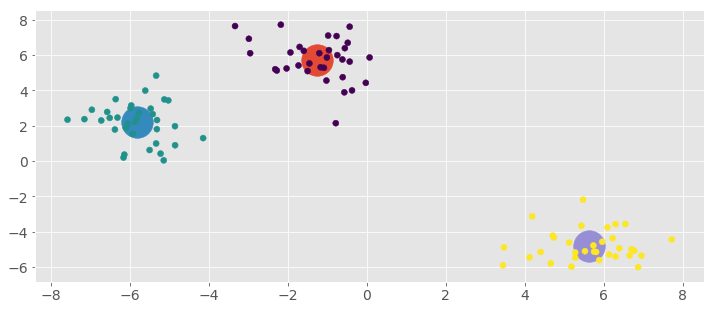

In [87]:
## Работоспособность MyKmeans
test(MyKmeans(k=3))

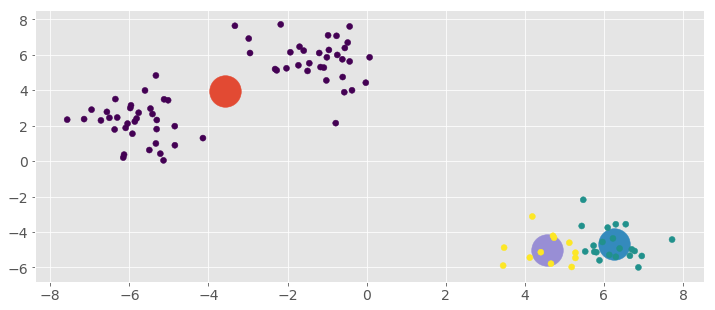

In [88]:
## Работоспособность MyKmeans++
test(MyKmeans(k=3, init='k-means++'))

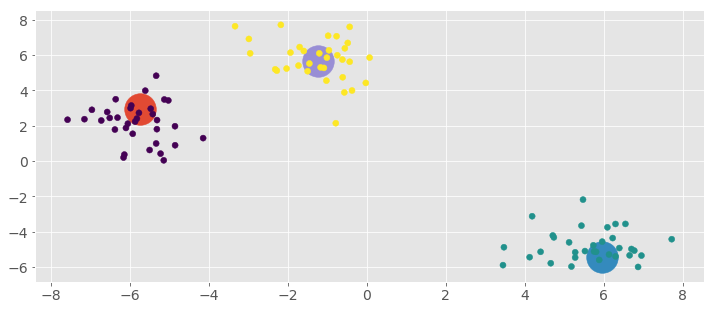

In [89]:
## Работоспособность MyKmeans с MiniBatchMyKmeans
test(MiniBatchKMeans(k=3))

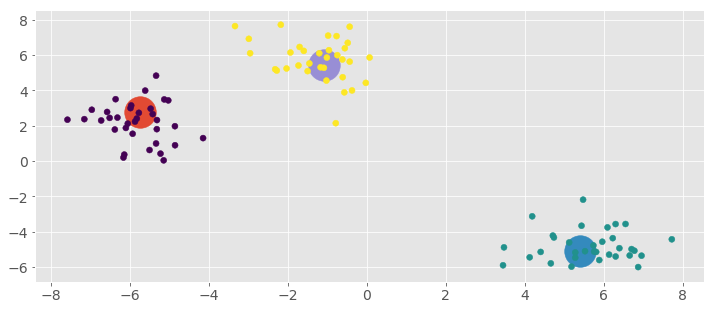

In [90]:
## Работоспособность MyKmeans++ с MiniBatchMyKmeans
test(MiniBatchKMeans(k=3, init='k-means++'))

In [91]:
def speed_test(model):
    model.fit(X)
    model.predict(X)

In [96]:
## Время выполнения алгоритма Kmeans из sklearn
from sklearn.cluster import KMeans

In [97]:
%%time
speed_test(KMeans(n_clusters=n_clusters))

CPU times: user 20.3 ms, sys: 209 µs, total: 20.5 ms
Wall time: 19.7 ms


In [98]:
## Время выполнения алгоритма MyKmeans

In [99]:
%%time
speed_test(MyKmeans(k=n_clusters))

CPU times: user 1.84 ms, sys: 266 µs, total: 2.11 ms
Wall time: 1.54 ms


In [100]:
## Время выполнения алгоритма MyKmeans++

In [101]:
%%time
speed_test(MyKmeans(k=n_clusters, init='k-means++'))

CPU times: user 2.26 ms, sys: 0 ns, total: 2.26 ms
Wall time: 1.63 ms


In [102]:
## Время выполнения алгоритма MyKmeans с MiniBatchMyKmeans

In [103]:
%%time
speed_test(MiniBatchKMeans(k=n_clusters))

CPU times: user 1.63 ms, sys: 988 µs, total: 2.62 ms
Wall time: 1.87 ms


In [104]:
## Время выполнения алгоритма  MyKmeans++ с MiniBatchMyKmeans

In [105]:
%%time
speed_test(MiniBatchKMeans(k=n_clusters, init='k-means++'))

CPU times: user 3.89 ms, sys: 0 ns, total: 3.89 ms
Wall time: 3.08 ms


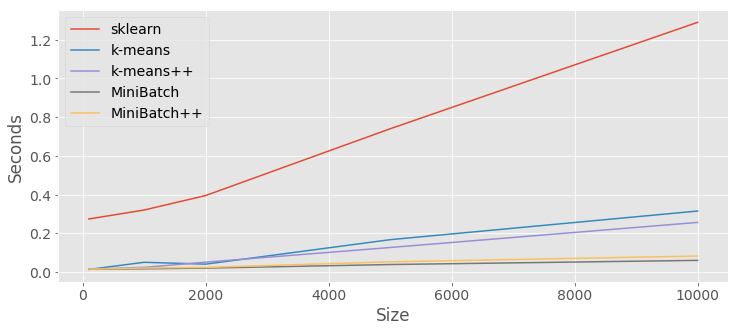

In [107]:
import timeit, functools

n = [100, 1000, 2000, 5000, 10000]
algs = ['sklearn', 'k-means', 'k-means++', 'MiniBatch', 'MiniBatch++']
time = [[], [], [], [], []]
models = [KMeans(n_clusters=n_clusters), MyKmeans(k=n_clusters), MyKmeans(k=n_clusters, init='k-means++')
          , MiniBatchKMeans(k=n_clusters), MiniBatchKMeans(k=n_clusters, init='k-means++')]

num_of_launch = 25

for n_samples in n:
    X, y = make_blobs(n_samples=n_samples, n_features=2, centers=3, cluster_std=1, 
               center_box=(-10.0, 10.0), shuffle=False, random_state=1234)
    for i, model in enumerate(models):
        t = timeit.Timer(functools.partial(speed_test, model)) 
        time[i].append(t.timeit(num_of_launch))

for i,alg in enumerate(algs):
    plt.plot(n, time[i], label=alg)

plt.xlabel('Size')
plt.ylabel('Seconds')
plt.legend()
plt.show()

# Применение K-means на реальных данных

Загрузите [данные](https://github.com/brenden17/sklearnlab/blob/master/facebook/snsdata.csv) в которых содержится описание интересов профилей учеников старшей школы США.  (без этого пункта задание не считается выполненным).   
ВНИМАНИЕ! Проверка должна быть осуществлена на всех реализациях, иначе реализация не будет зачтена!

In [24]:
df_sns = pd.read_csv('snsdata.csv', sep=',')

,gradyear,gender,age,friends,basketball,football,soccer,softball,volleyball,swimming,...,blonde,mall,shopping,clothes,hollister,abercrombie,die,death,drunk,drugs
0,2006,M,18.982,7,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2006,F,18.801,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,2006,M,18.335,69,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,2006,F,18.875,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2006,NaN,18.995,10,0,0,0,0,0,0,...,0,0,2,0,0,0,0,0,1,1


Данные устроены так: 
* Год выпуска
* Пол
* Возраст
* Количество друзей
* 36 ключевых слов, которые встречаются в профилe facebook (интересы, сообщества, встречи)

* Удалите все признаки кроме 36 ключевых слов.
* Нормализуйте данные - из каждого столбца вычтите его среднее значение и поделите на стандартное отклонение.
* Используйте метод k-means чтобы выделить 9 кластеров
* Попробуйте проинтерпретировать каждый кластер проанализировав полученные центройды (Некоторые кластеры могут быть очень большие и очень маленькие - плохо интерпретируются)   
КОММЕНТАРИИ НЕ СТИРАТЬ!

In [25]:
n_clusters=9
top_n=5

In [26]:
sns = df_sns.drop(df_sns.columns[:4], axis=1)
sns = (sns - sns.mean(axis=0)) / sns.std(axis=0)

In [27]:
def prediction(model):
    model.fit(sns.values)
    y = model.predict(sns.values)
    labeled_sns = sns
    labeled_sns.loc[:, 'label'] = y
    
    for (c, group) in labeled_sns.groupby('label'):
        print('Cluster: %d' % c)
        print('Size: %d' % len(group))
        print(group.iloc[:,:-1].mean().nlargest(top_n))
        print("=" * 10 + '\n')

In [28]:
## MyKMeans

In [35]:
%%time
prediction(MyKmeans(k=n_clusters))

Cluster: 0
Size: 2954
shopping    1.142715
cute        0.978839
dance       0.891625
mall        0.827502
clothes     0.775926
dtype: float64

Cluster: 1
Size: 356
volleyball    6.957456
softball      0.697258
basketball    0.638201
sports        0.418425
shopping      0.354161
dtype: float64

Cluster: 2
Size: 1073
kissed    2.845765
drugs     2.535856
hair      2.422176
sex       1.897368
drunk     1.741023
dtype: float64

Cluster: 3
Size: 807
hollister      4.186576
abercrombie    4.005778
shopping       0.746051
mall           0.536630
clothes        0.522155
dtype: float64

Cluster: 4
Size: 233
baseball      8.387071
football      1.060031
basketball    0.830474
sports        0.723274
rock          0.389064
dtype: float64

Cluster: 5
Size: 454
bible     4.911422
jesus     3.343942
god       3.134924
church    2.023860
death     0.348645
dtype: float64

Cluster: 6
Size: 580
marching    5.275589
band        4.162814
music       0.525979
rock        0.176792
football    0.067625
dtype

In [30]:
## MyKMeans++

In [36]:
%%time
prediction(MyKmeans(k=n_clusters, init='k-means++'))

Cluster: 0
Size: 20973
marching    0.016026
band       -0.024825
blonde     -0.027860
tennis     -0.050787
hot        -0.056541
dtype: float64

Cluster: 1
Size: 389
volleyball    6.778087
softball      0.650898
basketball    0.622964
shopping      0.417630
sports        0.395923
dtype: float64

Cluster: 2
Size: 3814
shopping       1.053869
cute           0.853644
mall           0.781726
abercrombie    0.757674
hollister      0.746647
dtype: float64

Cluster: 3
Size: 98
die      9.230956
death    4.994750
hair     0.953426
god      0.945034
sexy     0.833822
dtype: float64

Cluster: 4
Size: 585
kissed     4.747669
hair       2.965566
sex        2.705975
rock       1.812091
clothes    1.718398
dtype: float64

Cluster: 5
Size: 542
bible     4.583917
god       1.944714
jesus     1.859452
church    1.686771
music     0.243221
dtype: float64

Cluster: 6
Size: 379
drugs    5.712719
drunk    2.582569
hair     1.989415
die      1.264203
sex      1.140508
dtype: float64

Cluster: 7
Size: 3193
fo

In [ ]:
## MyKMeans с MiniBatchMyKMeans

In [37]:
%%time
prediction(MiniBatchKMeans(k=n_clusters, mbatch_size = len(sns) // 10, eps=10))

Cluster: 0
Size: 3540
football      1.103284
basketball    1.042467
sports        0.859617
softball      0.820814
baseball      0.730158
dtype: float64

Cluster: 1
Size: 1207
volleyball    1.669110
baseball      1.224896
basketball    0.468791
swimming      0.315348
church        0.101784
dtype: float64

Cluster: 2
Size: 1169
dress      3.057303
dance      1.384777
hair       1.297237
clothes    1.050473
kissed     0.969674
dtype: float64

Cluster: 3
Size: 2034
band        1.669273
marching    1.571079
cute        1.137317
music       0.424466
dance       0.266088
dtype: float64

Cluster: 4
Size: 628
sexy        4.522931
cute        0.524355
clothes     0.305716
hair        0.299671
shopping    0.293055
dtype: float64

Cluster: 5
Size: 554
soccer    4.031517
rock      2.644015
kissed    1.214953
hair      0.969799
sex       0.962359
dtype: float64

Cluster: 6
Size: 2074
shopping       1.418329
mall           1.389619
hot            1.276413
hollister      1.227852
abercrombie    1.1639

In [ ]:
## MyKMeans++ с MiniBatchMyKMeans

In [38]:
%%time
prediction(MiniBatchKMeans(k=n_clusters, mbatch_size = len(sns) // 10, eps=10, init='k-means++'))

Cluster: 0
Size: 641
abercrombie    4.493440
hollister      4.364724
shopping       0.882396
mall           0.827453
clothes        0.775052
dtype: float64

Cluster: 1
Size: 432
softball      6.453889
basketball    0.746510
volleyball    0.698726
sports        0.656167
baseball      0.273615
dtype: float64

Cluster: 2
Size: 18922
blonde   -0.028298
jesus    -0.036025
god      -0.047977
tennis   -0.048714
drunk    -0.058593
dtype: float64

Cluster: 3
Size: 2067
basketball    1.684224
soccer        1.239799
sports        1.216659
baseball      0.863405
football      0.483888
dtype: float64

Cluster: 4
Size: 817
football        3.607420
drugs           1.111002
baseball        0.732597
hair            0.641854
cheerleading    0.611315
dtype: float64

Cluster: 5
Size: 897
dress    4.106376
mall     0.710056
dance    0.703496
cute     0.685462
hair     0.598007
dtype: float64

Cluster: 6
Size: 1587
shopping    2.091834
mall        1.100883
hot         0.975911
clothes     0.820354
dance    

In [ ]:
## Вывод

Выбрать однозначного лидера не удалось, у каждого алгоритма есть преимущества и недостатки: лучше всего на игрушечных данных отработал k-means++, обычный k-means хорошо делил один кластер на два в силу случайности начального распределения центроидов, преимущества MiniBatch реализации были незаметны, а главным минусом MiniBatch являются дополнительные ручные параметры.

При прогонке алгоритмов на реальных данных k-means++ занимает больше всех времени,реализация . Судя по интересам пользователей в кластерах, качество кластеризации во всех случаях сравнимо.
Мой топ:
1. MiniBatch k-means
2. k-means
3. k-means++
